## Extracting Text from images using the Google Cloud Vision API

### Overview
In this Notebook, we learn how to extract text from the images using the Google Cloud Vision API. This Notebook demonstrates how to:

- upload image files to [Google Cloud Storage](https://cloud.google.com/storage)
- extract text from the images using the [Google Cloud Vision API](https://cloud.google.com/vision)
- translate the text using the [Google Cloud Translation API](https://cloud.google.com/translate)
- save your translations back to Cloud Storage. 

[Google Cloud Pub/Sub](https://cloud.google.com/pubsub) is used to queue various tasks and trigger the right Cloud Functions to carry them out.


### Objectives
We will learn how to perform the following tasks:

- Write and deploy several Background Cloud Functions.
- Upload images to Cloud Storage.
- Extract, translate and save text contained in uploaded images.

### Task 1. Visualize the flow of data

The flow of data in the Extract Text from the Images using the Google Cloud Vision API lab application involves several steps:

1. An image that contains text in any language is uploaded to Cloud Storage.

2. A Cloud Function is triggered, which uses the Vision API to extract the text and detect the source language.

3. The text is queued for translation by [publishing a message to a Pub/Sub topic](https://cloud.google.com/pubsub/docs/publisher). A translation is queued for each target language different from the source language.

4. If a target language matches the source language, the translation queue is skipped, and text is sent to the result queue, another Pub/Sub topic.

5. A Cloud Function uses the Translation API to translate the text in the translation queue. The translated result is sent to the result queue.

6. Another Cloud Function saves the translated text from the result queue to Cloud Storage.

7. The results are found in Cloud Storage as txt files for each translation.

It may help to visualize the steps:

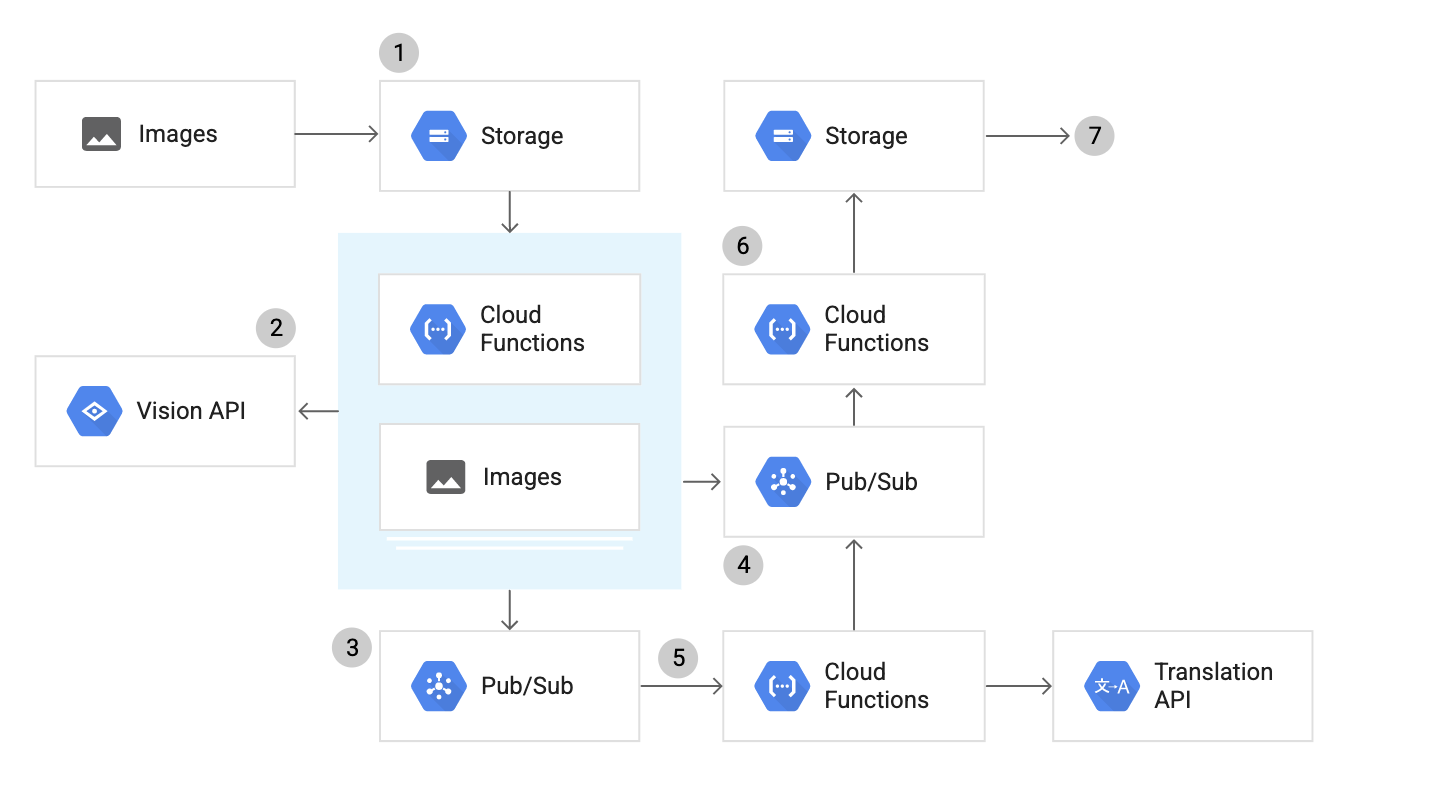

### Task 2. Prepare the application


1. Copy below script and paste it in the Cloud Shell. Before hitting the enter, change the bucket name (In order to set a unique name use your project ID because it is unique. For example, “image_bucket_YOUR_PROJECT_ID” can be your unique bucket name. Or feel free to choose any name as long as you use only lowercase letters, numbers, hyphens (-), underscores (_) and dots (.))

        gsutil mb gs://YOUR_IMAGE_BUCKET_NAME
        
2. Copy below script and paste it in the Cloud Shell. Before hitting the enter, change the bucket name (In order to set a unique name use your project ID because it is unique. For example, “result_bucket_YOUR_PROJECT_ID” can be your unique bucket name. Or feel free to choose any name as long as you use only lowercase letters, numbers, hyphens (-), underscores (_) and dots (.))

        gsutil mb gs://YOUR_RESULT_BUCKET_NAME

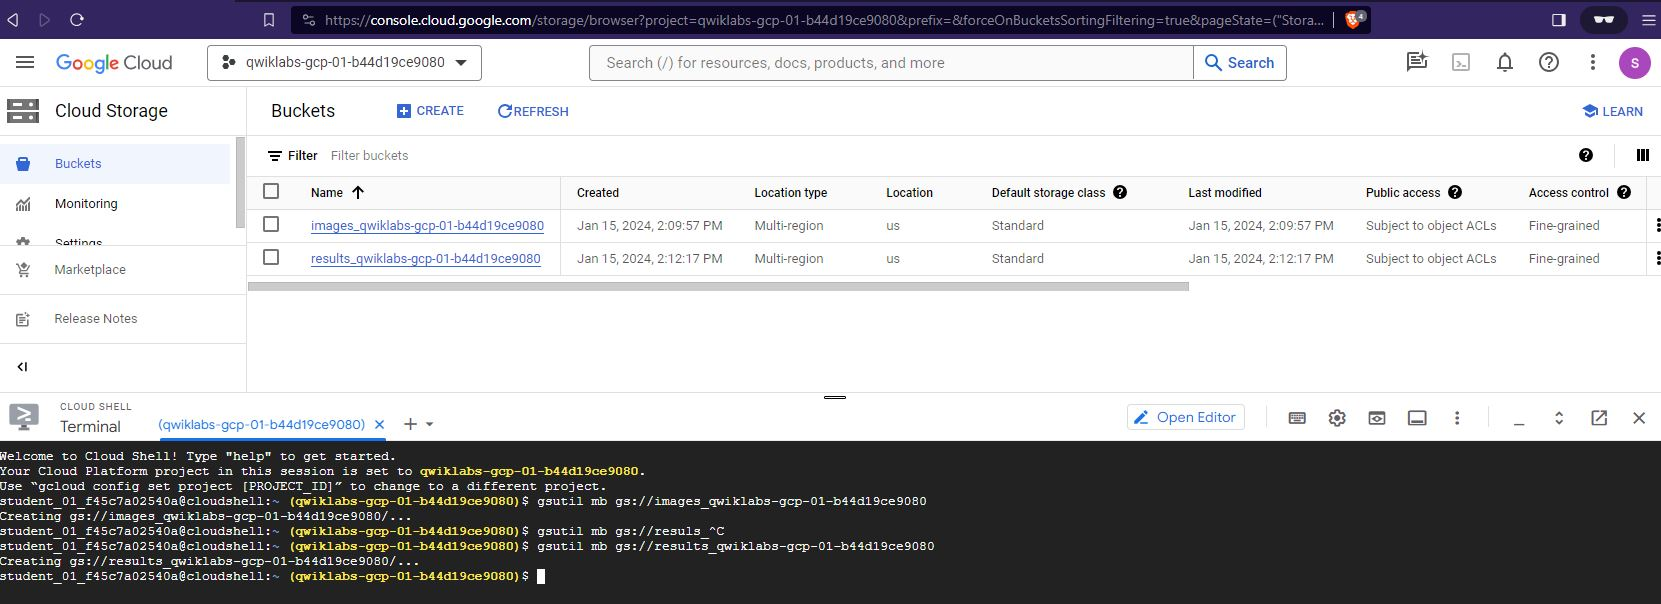
        

3. Copy below script and paste it in the Cloud Shell. Before hitting the enter, change YOUR_TRANSLATE_TOPIC_NAME.

        gcloud pubsub topics create YOUR_TRANSLATE_TOPIC_NAME
        
4. Copy below script and paste it in the Cloud Shell. Before hitting the enter, change YOUR_RESULT_TOPIC_NAME.

        gcloud pubsub topics create YOUR_RESULT_TOPIC_NAME
        
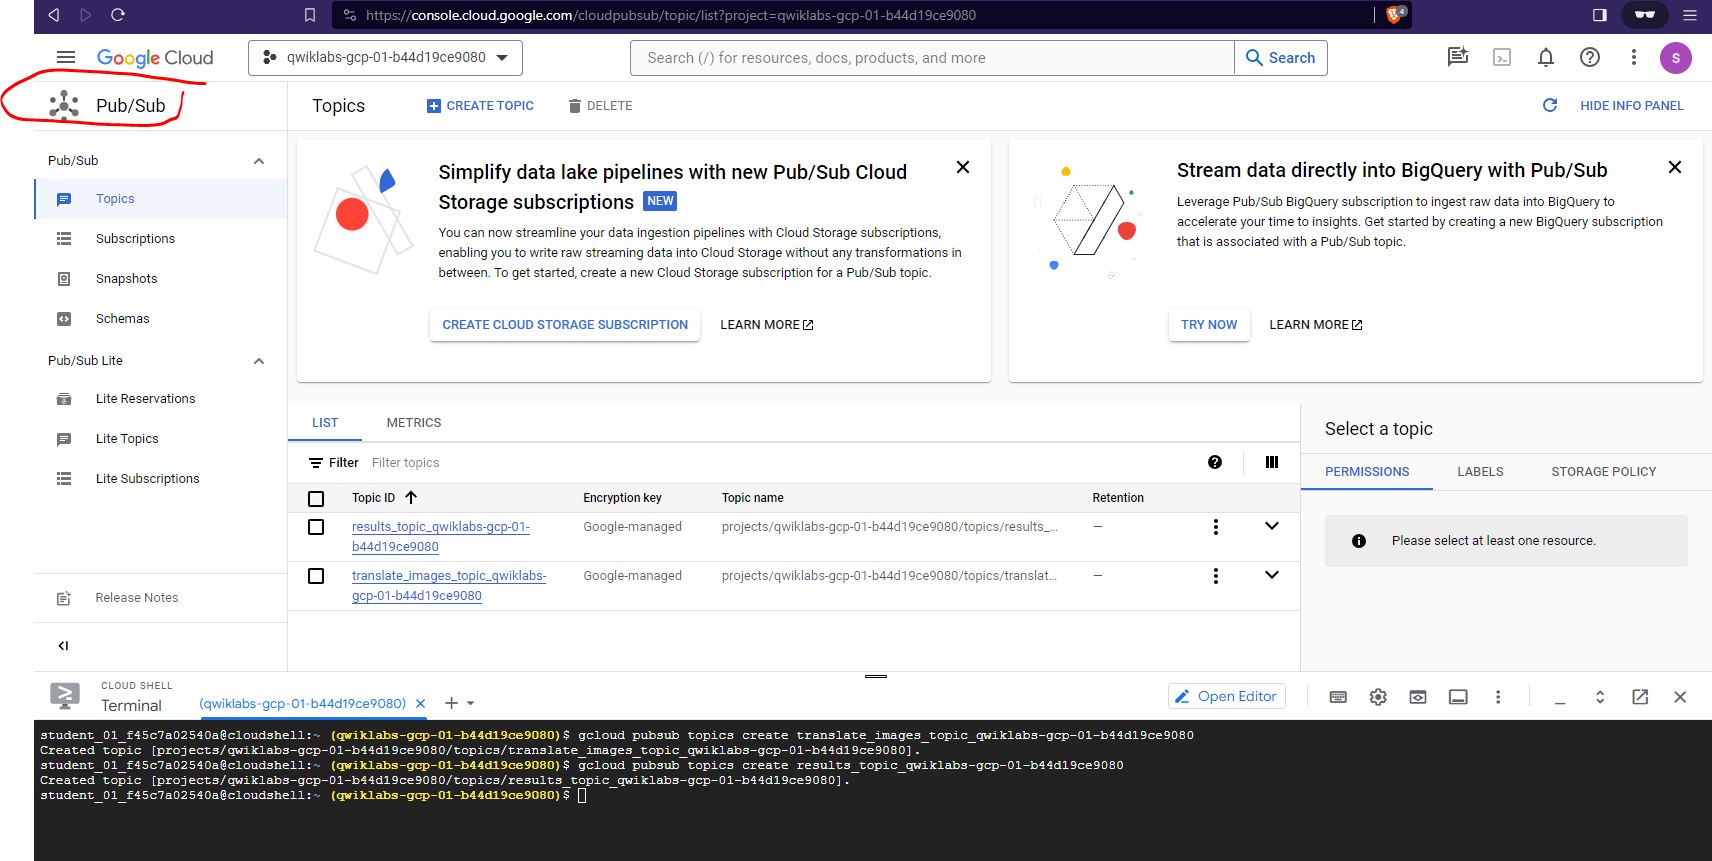

        
5. Clone the sample app repository to your Cloud Shell:

        git clone https://github.com/GoogleCloudPlatform/python-docs-samples.git
        
6. Change to the directory that contains the Cloud Functions sample code:

        cd python-docs-samples/functions/ocr/app/
        
7. python-docs-samples/functions/ocr/app/ folder consists of a `main.py` file which includes `ocr_detect`, `ocr_process`, `ocr_translate`, `ocr_ save` and `message_validatation_helper` functions defined in Task 1. Visualizing the flow of data.


### Task 3. Understand the code

#### Import dependencies
The application must import several dependencies in order to communicate with Google Cloud services:

`main.py`

In [ ]:
import base64
import json
import os
from google.cloud import pubsub_v1
from google.cloud import storage
from google.cloud import translate_v2 as translate
from google.cloud import vision
vision_client = vision.ImageAnnotatorClient()
translate_client = translate.Client()
publisher = pubsub_v1.PublisherClient()
storage_client = storage.Client()
project_id = os.environ["GCP_PROJECT"]

#### Process images

The following function reads an uploaded image file from Cloud Storage and calls a function to detect whether the image contains text:

In [ ]:
def process_image(file, context):
    """Cloud Function triggered by Cloud Storage when a file is changed.
    Args:
        file (dict): Metadata of the changed file, provided by the triggering
                                 Cloud Storage event.
        context (google.cloud.functions.Context): Metadata of triggering event.
    Returns:
        None; the output is written to stdout and Stackdriver Logging
    """
    bucket = validate_message(file, "bucket")
    name = validate_message(file, "name")
    detect_text(bucket, name)
    print("File {} processed.".format(file["name"]))

The following function extracts text from the image using the Cloud Vision API and queues the text for translation:

In [ ]:
def detect_text(bucket, filename):
    print("Looking for text in image {}".format(filename))
    futures = []
    image = vision.Image(
        source=vision.ImageSource(gcs_image_uri=f"gs://{bucket}/{filename}")
    )
    text_detection_response = vision_client.text_detection(image=image)
    annotations = text_detection_response.text_annotations
    if len(annotations) > 0:
        text = annotations[0].description
    else:
        text = ""
    print("Extracted text {} from image ({} chars).".format(text, len(text)))
    detect_language_response = translate_client.detect_language(text)
    src_lang = detect_language_response["language"]
    print("Detected language {} for text {}.".format(src_lang, text))
    # Submit a message to the bus for each target language
    to_langs = os.environ["TO_LANG"].split(",")
    for target_lang in to_langs:
        topic_name = os.environ["TRANSLATE_TOPIC"]
        if src_lang == target_lang or src_lang == "und":
            topic_name = os.environ["RESULT_TOPIC"]
        message = {
            "text": text,
            "filename": filename,
            "lang": target_lang,
            "src_lang": src_lang,
        }
        message_data = json.dumps(message).encode("utf-8")
        topic_path = publisher.topic_path(project_id, topic_name)
        future = publisher.publish(topic_path, data=message_data)
        futures.append(future)
    for future in futures:
        future.result()

#### Translate text

The following function translates the extracted text and queues the translated text to be saved back to Cloud Storage:

In [ ]:
def translate_text(event, context):
    if event.get("data"):
        message_data = base64.b64decode(event["data"]).decode("utf-8")
        message = json.loads(message_data)
    else:
        raise ValueError("Data sector is missing in the Pub/Sub message.")
    text = validate_message(message, "text")
    filename = validate_message(message, "filename")
    target_lang = validate_message(message, "lang")
    src_lang = validate_message(message, "src_lang")
    print("Translating text into {}.".format(target_lang))
    translated_text = translate_client.translate(
        text, target_language=target_lang, source_language=src_lang
    )
    topic_name = os.environ["RESULT_TOPIC"]
    message = {
        "text": translated_text["translatedText"],
        "filename": filename,
        "lang": target_lang,
    }
    message_data = json.dumps(message).encode("utf-8")
    topic_path = publisher.topic_path(project_id, topic_name)
    future = publisher.publish(topic_path, data=message_data)
    future.result()

#### Save the translations

Finally, the following function receives the translated text and saves it back to Cloud Storage:

In [ ]:
def save_result(event, context):
    if event.get("data"):
        message_data = base64.b64decode(event["data"]).decode("utf-8")
        message = json.loads(message_data)
    else:
        raise ValueError("Data sector is missing in the Pub/Sub message.")
    text = validate_message(message, "text")
    filename = validate_message(message, "filename")
    lang = validate_message(message, "lang")
    print("Received request to save file {}.".format(filename))
    bucket_name = os.environ["RESULT_BUCKET"]
    result_filename = "{}_{}.txt".format(filename, lang)
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(result_filename)
    print("Saving result to {} in bucket {}.".format(result_filename, bucket_name))
    blob.upload_from_string(text)
    print("File saved.")

### Task 4. Deploy the functions

This task describes how to deploy your functions.

1. To deploy the image processing function with a Cloud Storage trigger, run the following command in the directory that contains the sample code:

        gcloud functions deploy ocr-extract \
        --runtime python39 \
        --trigger-bucket YOUR_IMAGE_BUCKET_NAME \
        --entry-point process_image \
        --set-env-vars "^:^GCP_PROJECT=YOUR_GCP_PROJECT_ID:TRANSLATE_TOPIC=YOUR_TRANSLATE_TOPIC_NAME:RESULT_TOPIC=YOUR_RESULT_TOPIC_NAME:TO_LANG=es,en,fr,ja"
    
    
You can use the following values for the --runtime flag to specify your preferred Python version:

- python39 (recommended)
- python38
- python37

where `YOUR_IMAGE_BUCKET_NAME` is the name of your Cloud Storage bucket where you upload the images.

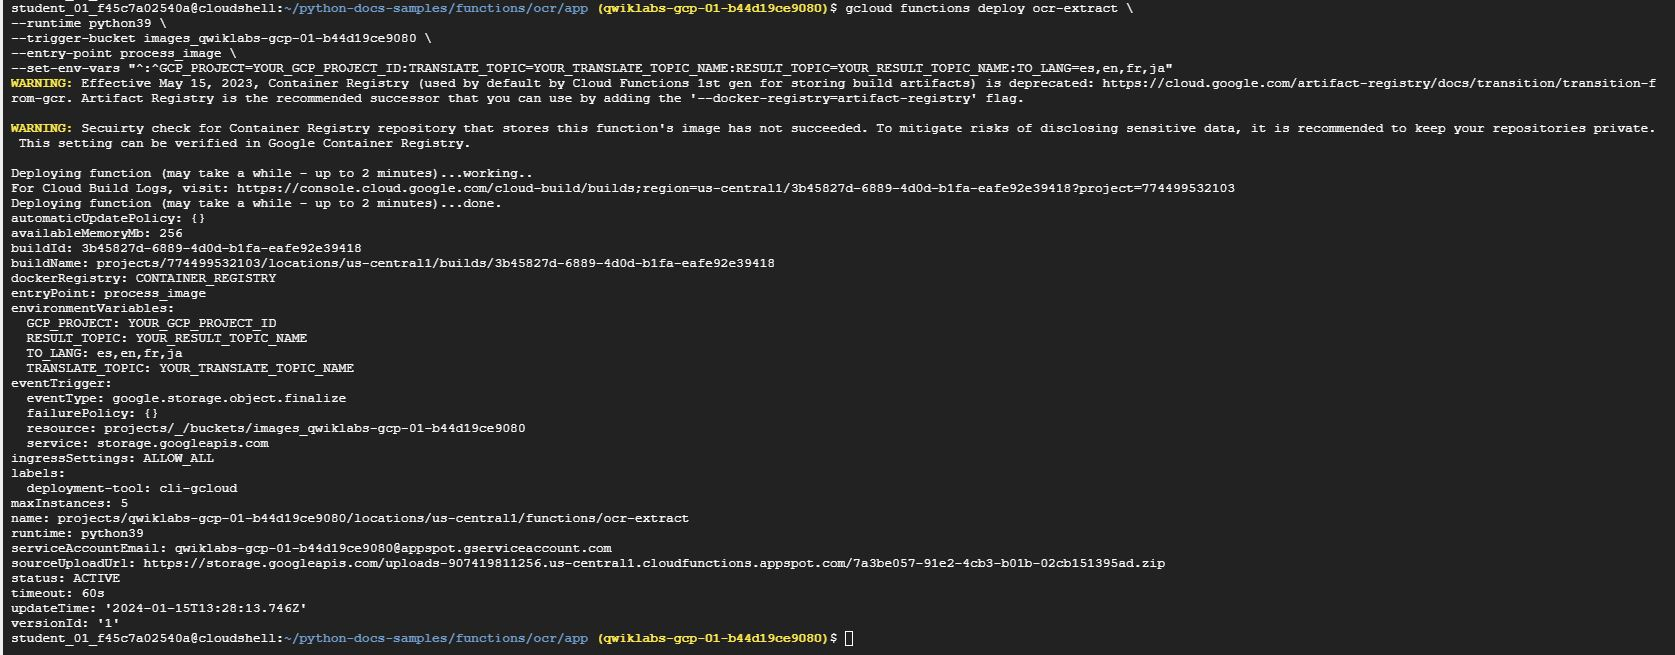

2. To deploy the text translation function with a Cloud Pub/Sub trigger, run the following command in the directory that contains the sample code:


        gcloud functions deploy ocr-translate \
        --runtime python39 \
        --trigger-topic YOUR_TRANSLATE_TOPIC_NAME \
        --entry-point translate_text \
        --set-env-vars "GCP_PROJECT=YOUR_GCP_PROJECT_ID,RESULT_TOPIC=YOUR_RESULT_TOPIC_NAME"
        
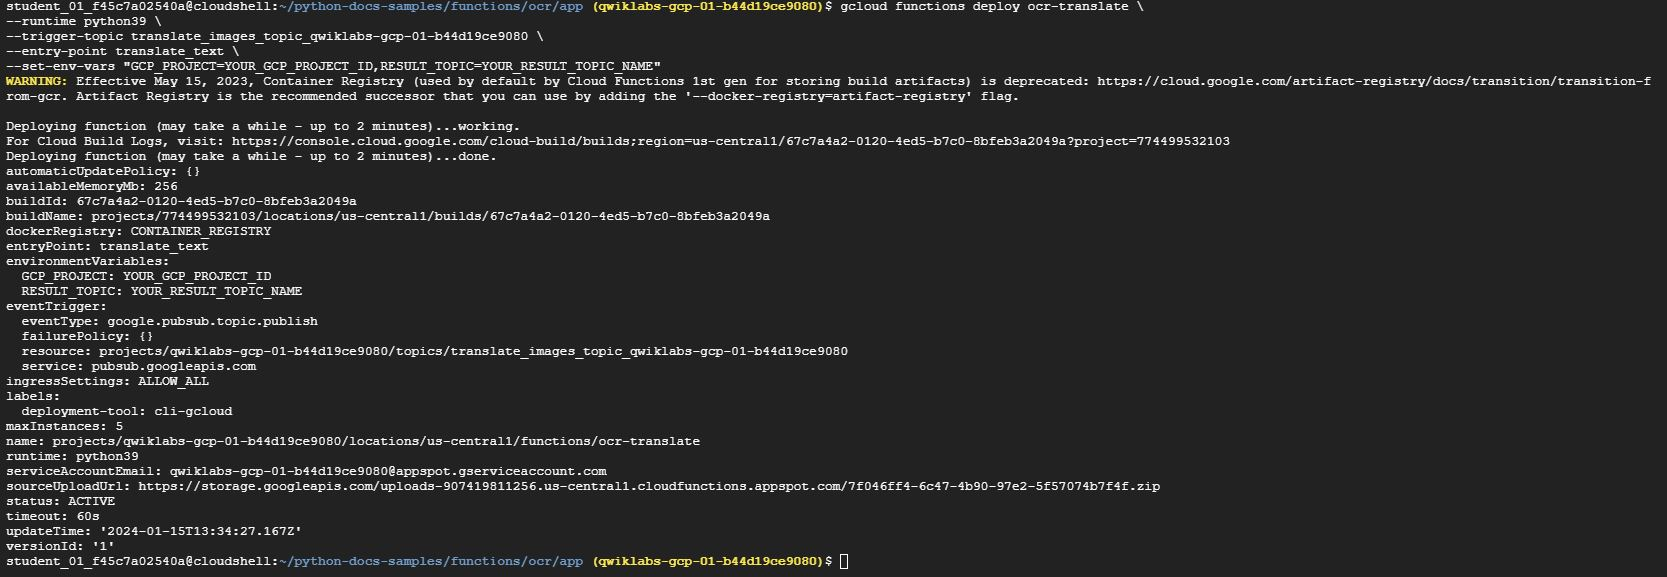
        

3. To deploy the function that saves results to Cloud Storage with a Cloud Pub/Sub trigger, run the following command in the directory that contains the sample code:

        gcloud functions deploy ocr-save \
        --runtime python39 \
        --trigger-topic YOUR_RESULT_TOPIC_NAME \
        --entry-point save_result \
        --set-env-vars "GCP_PROJECT=YOUR_GCP_PROJECT_ID,RESULT_BUCKET=YOUR_RESULT_BUCKET_NAME"       

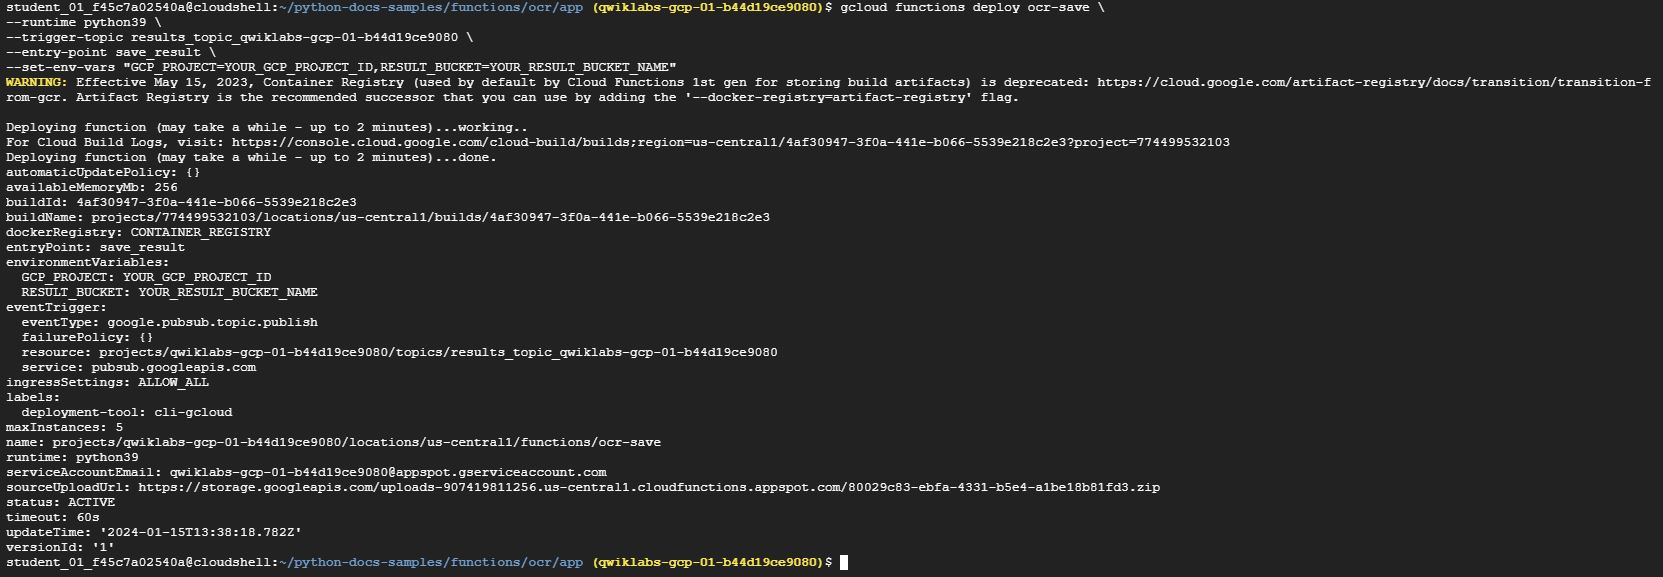

### Task 5. Upload an image

1. Upload an image to your image Cloud Storage bucket:

        gsutil cp PATH_TO_IMAGE gs://YOUR_IMAGE_BUCKET_NAME
        
where

- `PATH_TO_IMAGE` is a path to an image file (that contains text) on your local system.
- `YOUR_IMAGE_BUCKET_NAME` is the name of the bucket where you are uploading images.

You can download one of the images from the [sample project](https://github.com/GoogleCloudPlatform/nodejs-docs-samples/tree/master/functions/ocr/images).

2. Watch the logs to be sure the executions have completed:

        gcloud functions logs read --limit 100
        
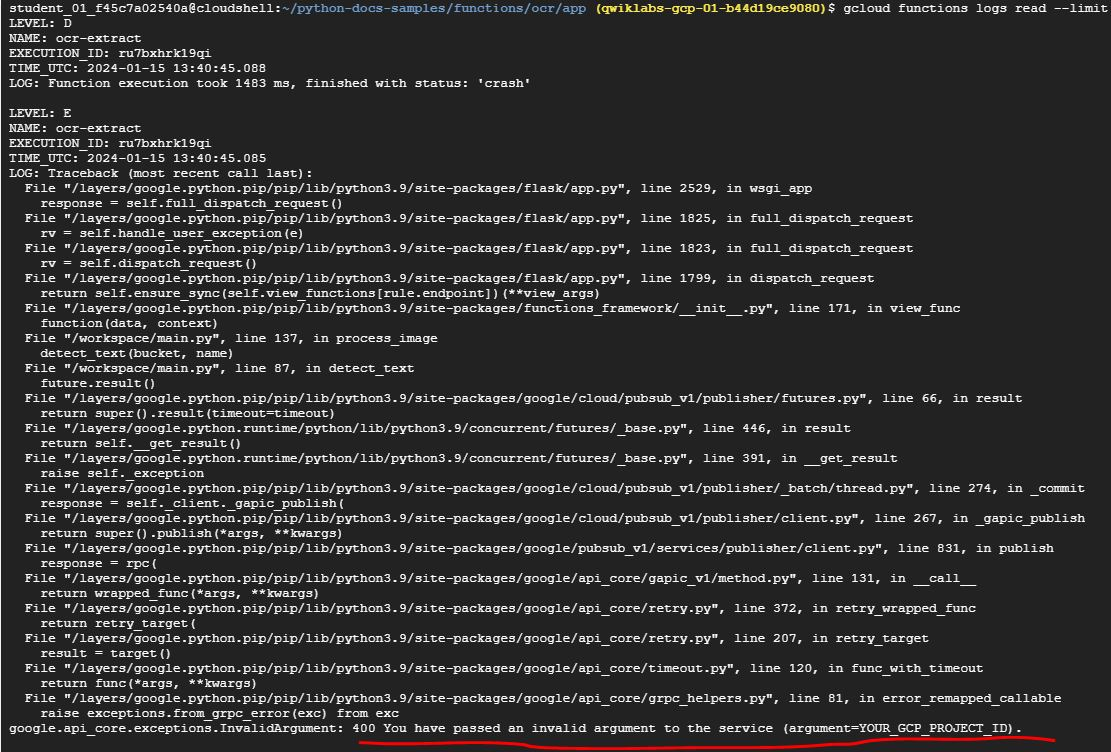

3. You can view the saved translations in the Cloud Storage bucket you used for YOUR_RESULT_BUCKET_NAME



### Task 6. Delete the Cloud Functions

Deleting Cloud Functions does not remove any resources stored in Cloud Storage.

To delete the Cloud Functions you created, run the following commands and follow the prompts:

    gcloud functions delete ocr-extract

    gcloud functions delete ocr-translate

    gcloud functions delete ocr-save
    
You can also delete Cloud Functions from the [Google Cloud](https://console.cloud.google.com/functions/list).